# PSPNet + EfficientNet B3

In [ ]:
!pip install q tensorflow==2.1
!pip install q keras==2.3.1
!pip install segmentation_models
import segmentation_models as sm

# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations==0.3.0 --user
# !pip install -U albumentations==0.2.3 --user 

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Requirement already up-to-date: albumentations==0.3.0 in /root/.local/lib/python3.7/site-packages (0.3.0)


In [ ]:
import os
# patchsize = 256

# Training data
x_train_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/train/images'
y_train_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/train/masks'

# Validation data
x_valid_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/test/images'
y_valid_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/test/masks'


x_test_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/testt/images'
y_test_dir = '/content/drive/MyDrive/Segmentation DS/384 DS Covid/Traintest/testt/masks'

print("Training and validation and test samples: ", len(os.listdir(x_train_dir)), len(os.listdir(x_valid_dir)), len(os.listdir(x_test_dir)))

Training and validation and test samples:  500 300 20


In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['target1' , 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()



#####################################################
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        # newer version of tf/keras want batch to be in tuple rather than list
        return tuple(batch)
#########################################################




    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

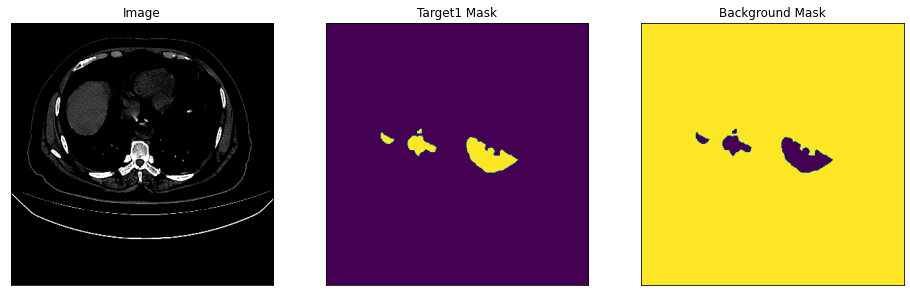

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['target1' , 'background'])

image, mask = dataset[43] # get some sample
visualize(
    image=image, 
    # target2_mask=mask[..., 2].squeeze(),
    target1_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 0].squeeze(),
)

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=384, min_width=384, always_apply=True, border_mode=0),
        A.RandomCrop(height=384, width=384, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        # A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 384)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        # A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

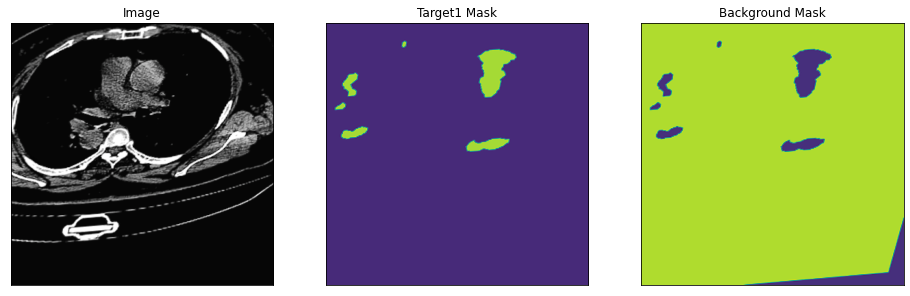

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['target1', 'background'], augmentation=get_training_augmentation())

image, mask = dataset[30] # get some sample
visualize(
    image=image, 
    # cars_mask=mask[..., 0].squeeze(),
    target1_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 0].squeeze(),
)

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)



# model = sm.PSPNet(BACKBONE,  encoder_weights='imagenet', activation=activation, input_shape = (384, 384, 3))
# I personally would chose (None, None, 3) for the input shape
#

In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./PSPEB3.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 503s 8s/step - loss: 0.2054 - iou_score: 0.8273 - f1-score: 0.9004 - val_loss: 0.1031 - val_iou_score: 0.9820 - val_f1-score: 0.9908
Epoch 2/10
62/62 [==============================] - 44s 708ms/step - loss: 0.1541 - iou_score: 0.8753 - f1-score: 0.9329 - val_loss: 0.0979 - val_iou_score: 0.9724 - val_f1-score: 0.9859
Epoch 3/10
62/62 [==============================] - 44s 711ms/step - loss: 0.1356 - iou_score: 0.8933 - f1-score: 0.9433 - val_loss: 0.0817 - val_iou_score: 0.9762 - val_f1-score: 0.9878
Epoch 4/10
62/62 [==============================] - 44s 709ms/step - loss: 0.1226 - iou_score: 0.9033 - f1-score: 0.9489 - val_loss: 0.0744 - val_iou_score: 0.9728 - val_f1-score: 0.9860
Epoch 5/10
62/62 [==============================] - 44s 709ms/step - loss: 0.1190 - iou_score: 0.9057 - f1-score: 0.9503 - val_loss: 0.0723 - val_iou_score: 0.9683 - val_f1-score: 0.9837
Epoch 6/10
62/62 [==============================] - 44s 712ms/step 

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.10554
mean iou_score: 0.92461
mean f1-score: 0.96062


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.067251
mean iou_score: 0.95236
mean f1-score: 0.97525


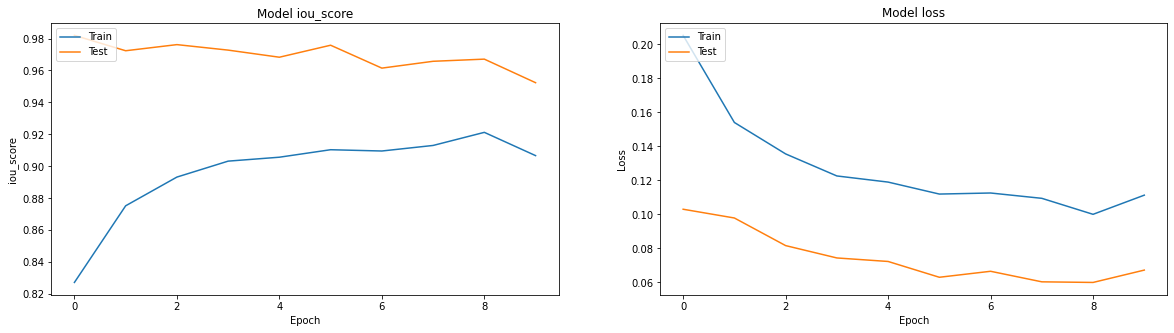

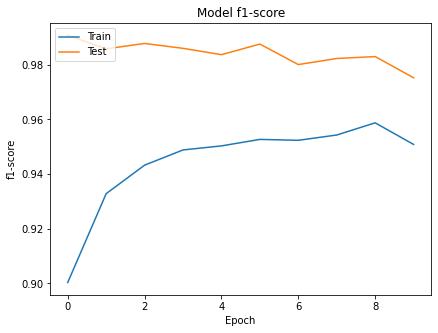

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.16041
mean iou_score: 0.92727
mean f1-score: 0.96217


# PSPNet + Inception Resnet V2

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'inceptionresnetv2'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)

219062272/219055592 [==============================] - 4s 0us/step


In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./PSPInReV2.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 50s 812ms/step - loss: 0.1870 - iou_score: 0.8514 - f1-score: 0.9155 - val_loss: 0.2568 - val_iou_score: 0.8557 - val_f1-score: 0.9221
Epoch 2/10
62/62 [==============================] - 29s 468ms/step - loss: 0.1328 - iou_score: 0.9047 - f1-score: 0.9498 - val_loss: 0.2433 - val_iou_score: 0.7553 - val_f1-score: 0.8590
Epoch 3/10
62/62 [==============================] - 29s 469ms/step - loss: 0.1099 - iou_score: 0.9206 - f1-score: 0.9585 - val_loss: 0.1677 - val_iou_score: 0.8428 - val_f1-score: 0.9145
Epoch 4/10
62/62 [==============================] - 29s 472ms/step - loss: 0.1092 - iou_score: 0.9183 - f1-score: 0.9573 - val_loss: 0.1115 - val_iou_score: 0.9274 - val_f1-score: 0.9621
Epoch 5/10
62/62 [==============================] - 30s 478ms/step - loss: 0.0945 - iou_score: 0.9294 - f1-score: 0.9633 - val_loss: 0.1350 - val_iou_score: 0.8372 - val_f1-score: 0.9111
Epoch 6/10
62/62 [==============================] - 29s 474ms/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.075628
mean iou_score: 0.94292
mean f1-score: 0.97052


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.064169
mean iou_score: 0.93286
mean f1-score: 0.96479


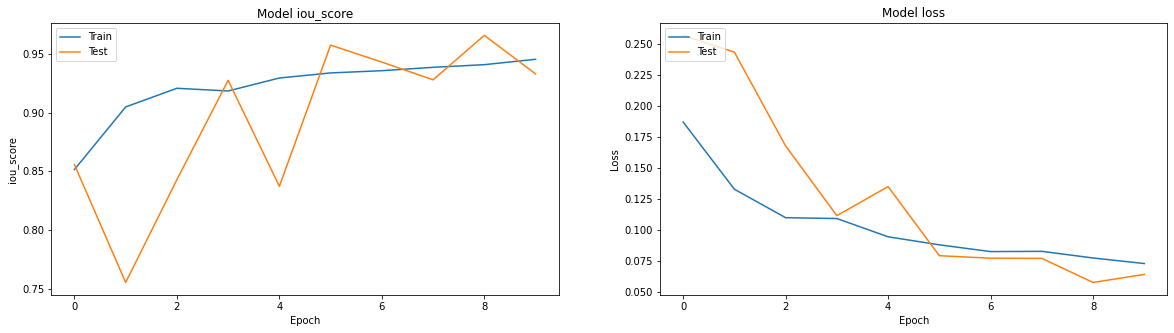

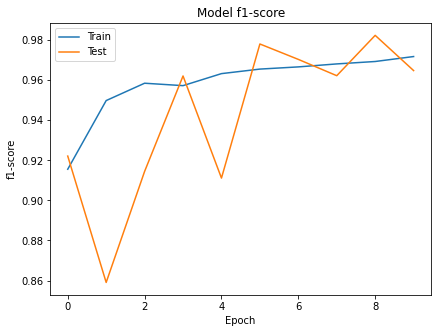

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.17157
mean iou_score: 0.95697
mean f1-score: 0.9779


# PSPNet + MobileNet V2

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'mobilenetv2'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./PSPMobilenetV2.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 32s 524ms/step - loss: 0.1967 - iou_score: 0.8415 - f1-score: 0.9124 - val_loss: 0.0551 - val_iou_score: 0.9833 - val_f1-score: 0.9914
Epoch 2/10
62/62 [==============================] - 25s 402ms/step - loss: 0.1626 - iou_score: 0.8669 - f1-score: 0.9281 - val_loss: 0.0586 - val_iou_score: 0.9831 - val_f1-score: 0.9914
Epoch 3/10
62/62 [==============================] - 25s 402ms/step - loss: 0.1350 - iou_score: 0.8925 - f1-score: 0.9429 - val_loss: 0.0587 - val_iou_score: 0.9811 - val_f1-score: 0.9903
Epoch 4/10
62/62 [==============================] - 25s 402ms/step - loss: 0.1242 - iou_score: 0.9022 - f1-score: 0.9482 - val_loss: 0.0615 - val_iou_score: 0.9625 - val_f1-score: 0.9806
Epoch 5/10
62/62 [==============================] - 25s 405ms/step - loss: 0.1130 - iou_score: 0.9132 - f1-score: 0.9542 - val_loss: 0.0865 - val_iou_score: 0.8856 - val_f1-score: 0.9361
Epoch 6/10
62/62 [==============================] - 25s 407ms/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11894
mean iou_score: 0.92558
mean f1-score: 0.96111


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.055484
mean iou_score: 0.94535
mean f1-score: 0.97157


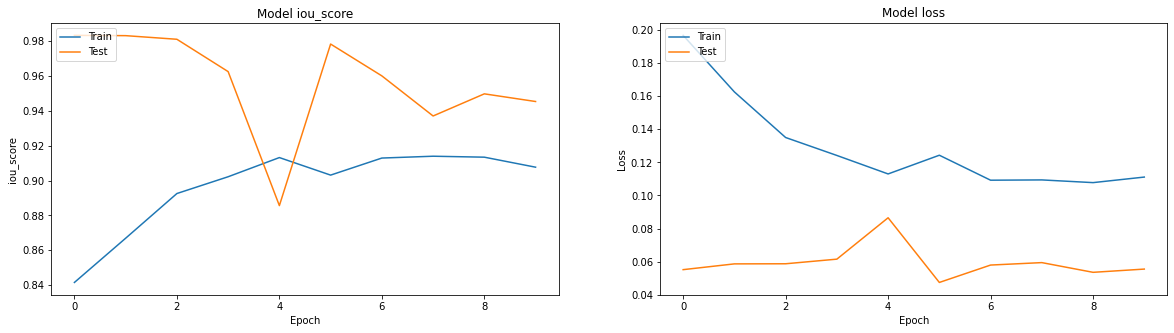

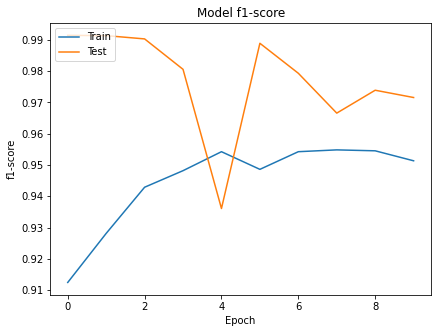

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11452
mean iou_score: 0.93244
mean f1-score: 0.96488


# PSPNet + Densenet 121

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'densenet121'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)

In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./PSPdensenet121.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 54s 874ms/step - loss: 0.1747 - iou_score: 0.8720 - f1-score: 0.9308 - val_loss: 0.2269 - val_iou_score: 0.8926 - val_f1-score: 0.9429
Epoch 2/10
62/62 [==============================] - 37s 594ms/step - loss: 0.1267 - iou_score: 0.9042 - f1-score: 0.9494 - val_loss: 0.1954 - val_iou_score: 0.8363 - val_f1-score: 0.9106
Epoch 3/10
62/62 [==============================] - 37s 599ms/step - loss: 0.1141 - iou_score: 0.9127 - f1-score: 0.9541 - val_loss: 0.1522 - val_iou_score: 0.8388 - val_f1-score: 0.9121
Epoch 4/10
62/62 [==============================] - 37s 602ms/step - loss: 0.1017 - iou_score: 0.9217 - f1-score: 0.9591 - val_loss: 0.1042 - val_iou_score: 0.9046 - val_f1-score: 0.9495
Epoch 5/10
62/62 [==============================] - 37s 603ms/step - loss: 0.0993 - iou_score: 0.9243 - f1-score: 0.9605 - val_loss: 0.1338 - val_iou_score: 0.8280 - val_f1-score: 0.9055
Epoch 6/10
62/62 [==============================] - 37s 602ms/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.072911
mean iou_score: 0.951
mean f1-score: 0.97479


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.054556
mean iou_score: 0.95826
mean f1-score: 0.97845


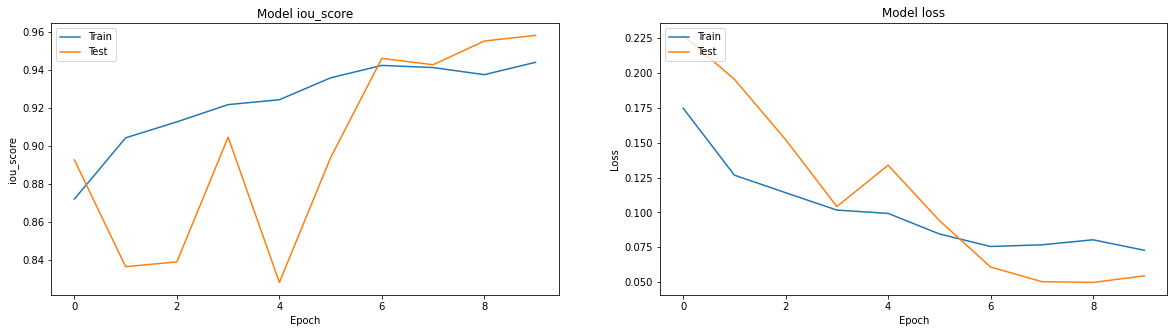

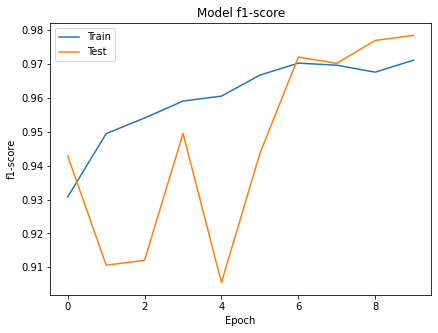

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.085853
mean iou_score: 0.95749
mean f1-score: 0.97749


# PSPNet + VGG19

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'vgg19'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)

In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./PSPVGG19.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 47s 754ms/step - loss: 0.2063 - iou_score: 0.8110 - f1-score: 0.8916 - val_loss: 0.0666 - val_iou_score: 0.9358 - val_f1-score: 0.9657
Epoch 2/10
62/62 [==============================] - 39s 627ms/step - loss: 0.1483 - iou_score: 0.8748 - f1-score: 0.9329 - val_loss: 0.2761 - val_iou_score: 0.5412 - val_f1-score: 0.6905
Epoch 3/10
62/62 [==============================] - 39s 632ms/step - loss: 0.1230 - iou_score: 0.9015 - f1-score: 0.9479 - val_loss: 0.3363 - val_iou_score: 0.5297 - val_f1-score: 0.6868
Epoch 4/10
62/62 [==============================] - 40s 639ms/step - loss: 0.1064 - iou_score: 0.9169 - f1-score: 0.9564 - val_loss: 0.3206 - val_iou_score: 0.5821 - val_f1-score: 0.7308
Epoch 5/10
62/62 [==============================] - 40s 644ms/step - loss: 0.0932 - iou_score: 0.9270 - f1-score: 0.9619 - val_loss: 0.2447 - val_iou_score: 0.7369 - val_f1-score: 0.8448
Epoch 6/10
62/62 [==============================] - 40s 648ms/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.077854
mean iou_score: 0.95124
mean f1-score: 0.97491


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.058444
mean iou_score: 0.94331
mean f1-score: 0.97062


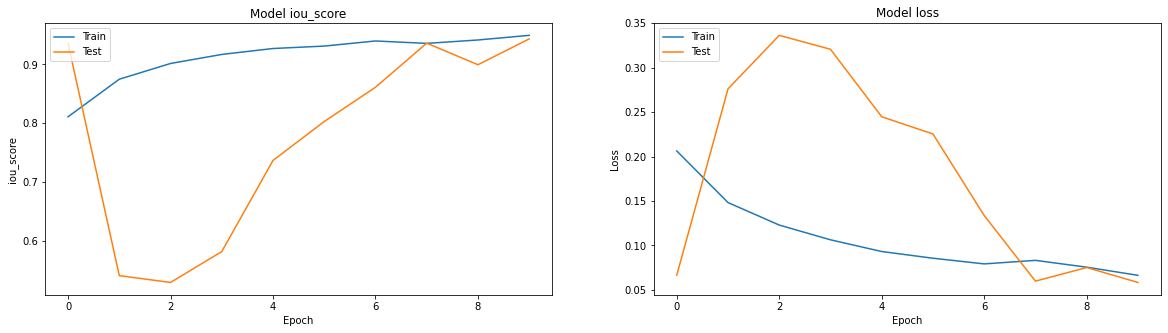

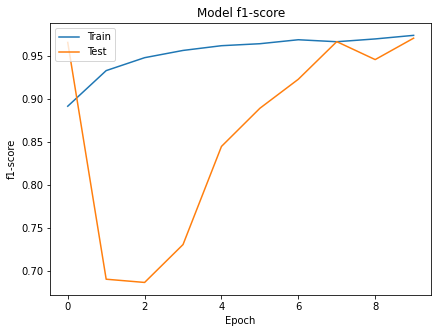

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.17845
mean iou_score: 0.85437
mean f1-score: 0.92137


# PSPNet + SeresNext 101

In [ ]:
import segmentation_models as sm

In [ ]:
BACKBONE = 'seresnext101'
BATCH_SIZE = 8
CLASSES = ['target1']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)

In [ ]:
model.summary()

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('./PSPseresnext101.csv', separator=",", append=True)
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
62/62 [==============================] - 73s 1s/step - loss: 0.1689 - iou_score: 0.8619 - f1-score: 0.9246 - val_loss: 0.0553 - val_iou_score: 0.9833 - val_f1-score: 0.9914
Epoch 2/10
62/62 [==============================] - 52s 836ms/step - loss: 0.1150 - iou_score: 0.9077 - f1-score: 0.9513 - val_loss: 0.0618 - val_iou_score: 0.9779 - val_f1-score: 0.9887
Epoch 3/10
62/62 [==============================] - 52s 842ms/step - loss: 0.1021 - iou_score: 0.9186 - f1-score: 0.9574 - val_loss: 0.0555 - val_iou_score: 0.9808 - val_f1-score: 0.9901
Epoch 4/10
62/62 [==============================] - 52s 846ms/step - loss: 0.0995 - iou_score: 0.9197 - f1-score: 0.9580 - val_loss: 0.0504 - val_iou_score: 0.9825 - val_f1-score: 0.9910
Epoch 5/10
62/62 [==============================] - 53s 847ms/step - loss: 0.0926 - iou_score: 0.9279 - f1-score: 0.9623 - val_loss: 0.0610 - val_iou_score: 0.9819 - val_f1-score: 0.9907
Epoch 6/10
62/62 [==============================] - 53s 849ms/step -

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.083062
mean iou_score: 0.93645
mean f1-score: 0.96698


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



# Plot training & validation f1_score values
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [ ]:
# load best weights
# model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11934
mean iou_score: 0.9157
mean f1-score: 0.95588
